In [10]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib

cutoff_begin = "2024-12-16T03:15:35.626996+01:00"
cutoff_end = "2025-02-01T03:15:35.626997+01:00"

load_gin(exp_name="ingest-kafka", test=False)


In [11]:
def plot_throughput_vs_memory(enriched_data: pd.DataFrame):
    # Restack this to show memory impact 
    redpanda_df = enriched_data[enriched_data["exp_name"] == "ingest-redpanda"]
    kafka_df = enriched_data[enriched_data["exp_name"] == "ingest-kafka"]

    # Add a new column for memory in MiB
    redpanda_df['broker_mem_mib'] = redpanda_df['broker_mem'].apply(convert_to_mib)
    min_throughput = min(redpanda_df['throughput_MBps'].min(), kafka_df['throughput_MBps'].min())
    min_throughput = 0
    max_throughput = max(redpanda_df['throughput_MBps'].max(), kafka_df['throughput_MBps'].max())

    kafka_df['broker_mem_mib'] = kafka_df['broker_mem'].apply(convert_to_mib)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(data=redpanda_df, x='broker_cpu', y='throughput_MBps', hue='broker_mem_mib', palette='viridis')
    # sns.pointplot(data=redpanda_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu')

    plt.title('Redpanda')
    plt.xlabel('Cores')
    plt.ylabel('Throughput (MBps)')
    plt.legend(title='Memory')
    plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # sns.scatterplot(data=kafka_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu', palette='viridis', alpha=0.7)
    sns.barplot(data=kafka_df, x='broker_cpu', y='throughput_MBps', hue='broker_mem_mib', palette='viridis')
    plt.title('Kafka')
    plt.xlabel('Cores')
    plt.ylabel('Throughput (MBps)')
    plt.legend(title='Memory')
    plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
    plt.grid(True)
    plt.show()

In [12]:
# ovhnvme_1 = an.full_analytical_pipeline(
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
#     cluster="ovhnvme",
#     type="memImpact",
#     partitions=1,
# )
# ovhnvme_100 = an.full_analytical_pipeline(
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
#     cluster="ovhnvme",
#     type="memImpact",
#     partitions=100,
# )
grappe_1 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="grappe",
    type="memImpact",
    partitions=1,
)
grappe_120 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="grappe",
    type="memImpact",
    partitions=120,
)
taurus_1 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="taurus",
    type="memImpact",
    partitions=1,
)
taurus_100 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="taurus",
    type="memImpact",
    partitions=120,
)

In [13]:
# plot_throughput_vs_memory(ovhnvme_1)
# plot_throughput_vs_memory(ovhnvme_100)
taurus_1 = taurus_1[taurus_1["broker_cpu"].astype(int) <= 8]
taurus_1 = taurus_1[taurus_1["broker_mem"] != "25Gi"]
taurus_100 = taurus_100[taurus_100["broker_cpu"].astype(int) <= 8]
taurus_100 = taurus_100[taurus_100["broker_mem"] != "25Gi"]

In [14]:
# plot_throughput_vs_memory(grappe_1)
# plot_throughput_vs_memory(grappe_100)

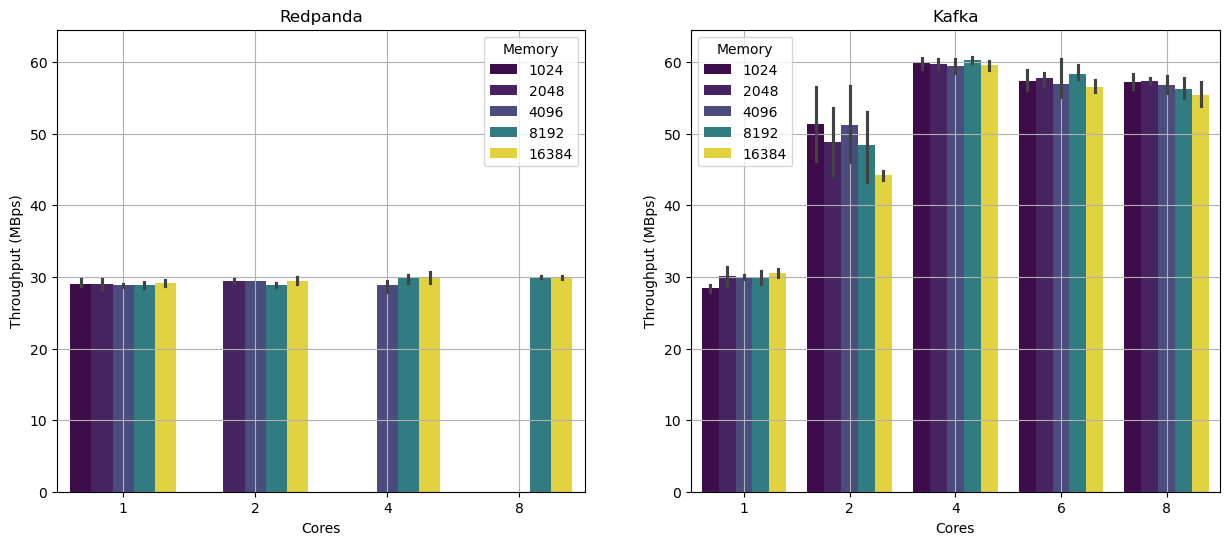

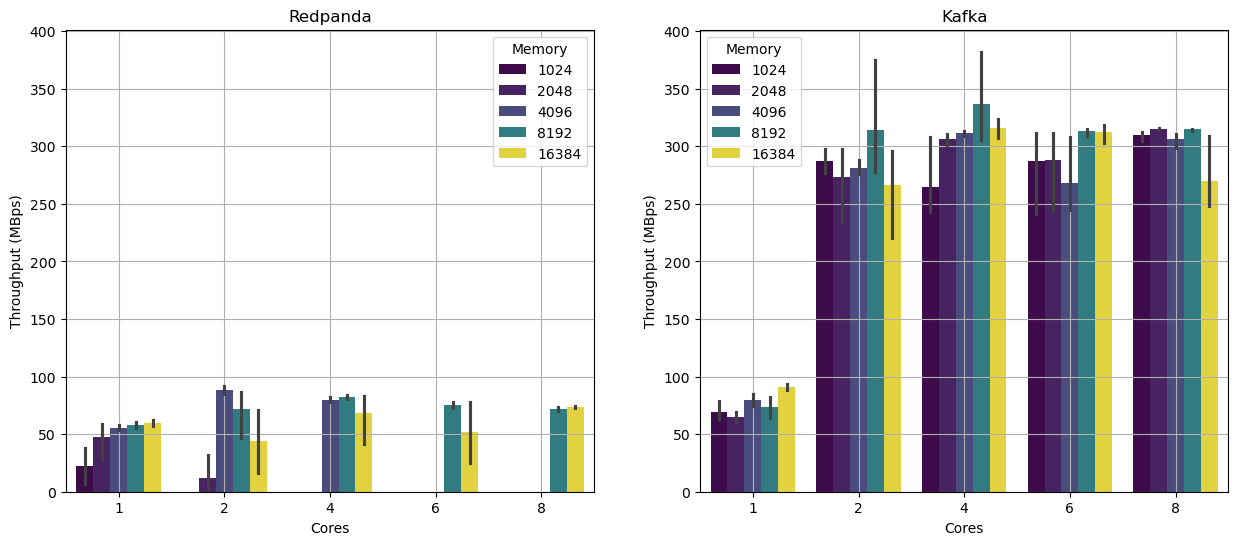

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [15]:
plot_throughput_vs_memory(taurus_1)
plot_throughput_vs_memory(taurus_100)
an.create_qgrid_widget(taurus_1)

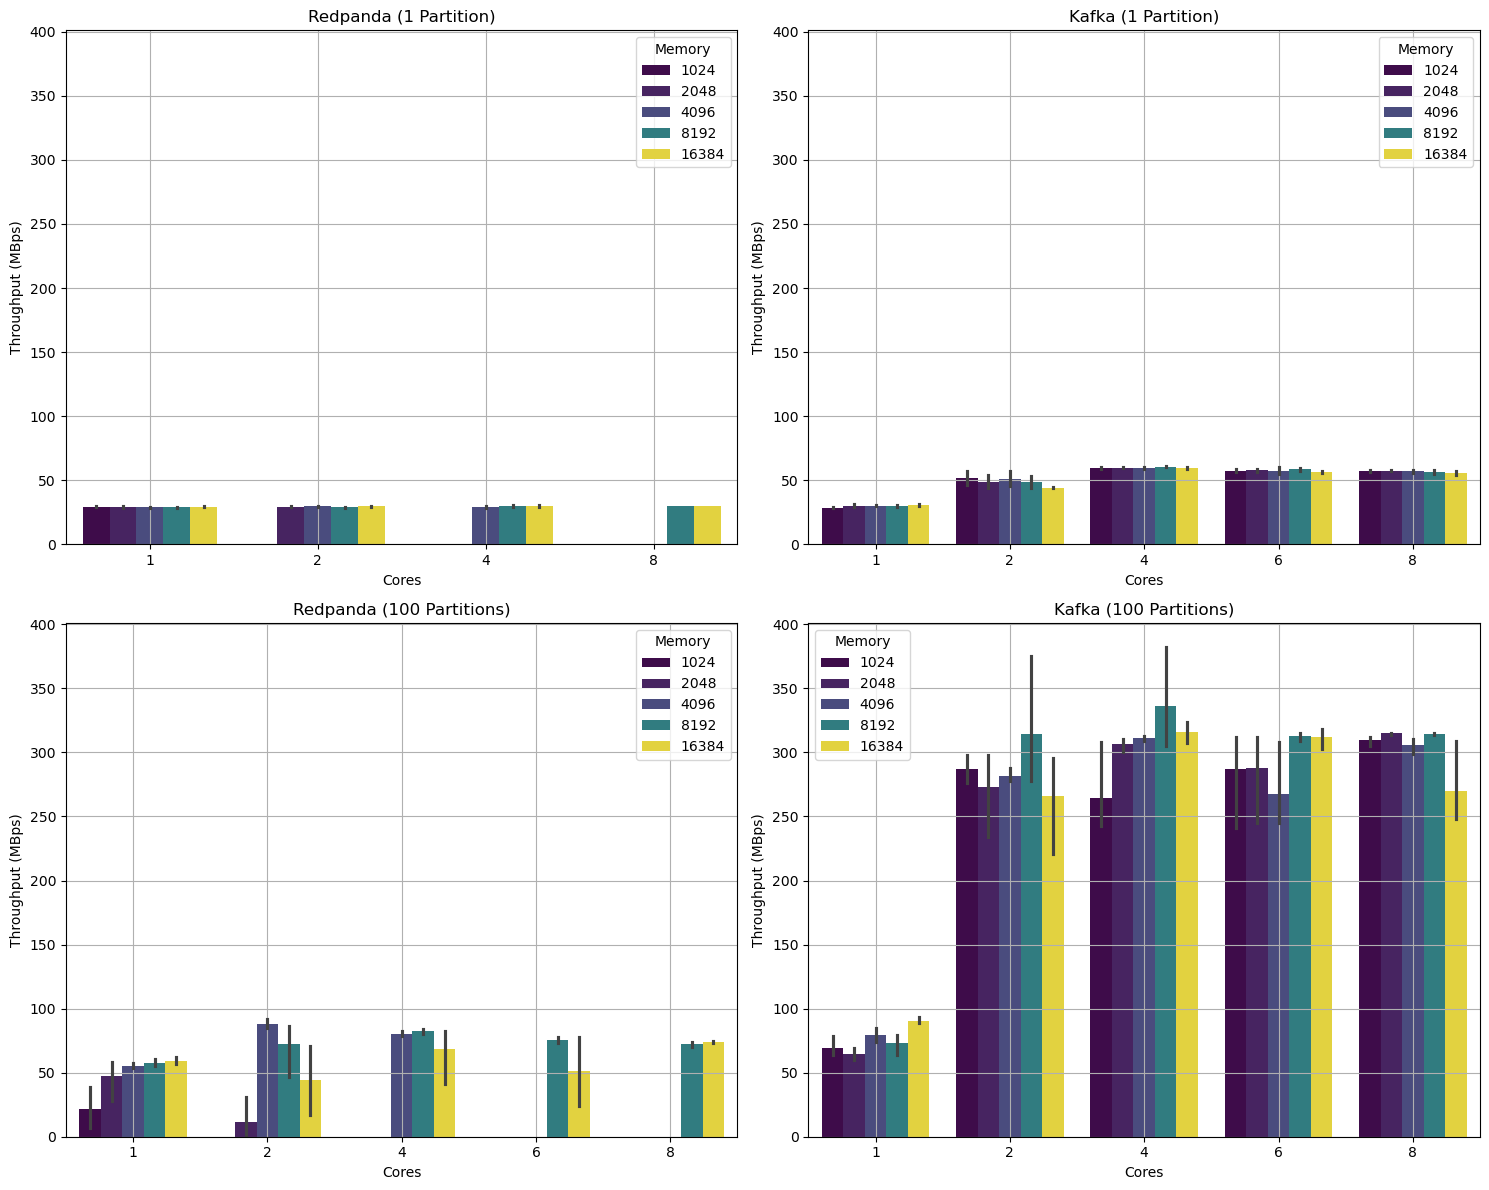

In [16]:
def plot_combined_throughput(df1: pd.DataFrame, df2: pd.DataFrame):
    # Process first dataframe
    redpanda_df1 = df1[df1["exp_name"] == "ingest-redpanda"]
    kafka_df1 = df1[df1["exp_name"] == "ingest-kafka"]
    redpanda_df1['broker_mem_mib'] = redpanda_df1['broker_mem'].apply(convert_to_mib)
    kafka_df1['broker_mem_mib'] = kafka_df1['broker_mem'].apply(convert_to_mib)
    
    # Process second dataframe
    redpanda_df2 = df2[df2["exp_name"] == "ingest-redpanda"]
    kafka_df2 = df2[df2["exp_name"] == "ingest-kafka"]
    redpanda_df2['broker_mem_mib'] = redpanda_df2['broker_mem'].apply(convert_to_mib)
    kafka_df2['broker_mem_mib'] = kafka_df2['broker_mem'].apply(convert_to_mib)
    
    # Find global min/max for consistent y-axis
    min_throughput = min(
        redpanda_df1['throughput_MBps'].min(),
        kafka_df1['throughput_MBps'].min(),
        redpanda_df2['throughput_MBps'].min(),
        kafka_df2['throughput_MBps'].min(),
        0
    )
    max_throughput = max(
        redpanda_df1['throughput_MBps'].max(),
        kafka_df1['throughput_MBps'].max(),
        redpanda_df2['throughput_MBps'].max(),
        kafka_df2['throughput_MBps'].max()
    )

    # Create figure with 4 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # First row - DataFrame 1
    sns.barplot(data=redpanda_df1, x='broker_cpu', y='throughput_MBps', 
                hue='broker_mem_mib', palette='viridis', ax=ax1)
    ax1.set_title('Redpanda (1 Partition)')
    ax1.set_xlabel('Cores')
    ax1.set_ylabel('Throughput (MBps)')
    ax1.legend(title='Memory')
    ax1.set_ylim(min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput)
    ax1.grid(True)

    sns.barplot(data=kafka_df1, x='broker_cpu', y='throughput_MBps', 
                hue='broker_mem_mib', palette='viridis', ax=ax2)
    ax2.set_title('Kafka (1 Partition)')
    ax2.set_xlabel('Cores')
    ax2.set_ylabel('Throughput (MBps)')
    ax2.legend(title='Memory')
    ax2.set_ylim(min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput)
    ax2.grid(True)

    # Second row - DataFrame 2
    sns.barplot(data=redpanda_df2, x='broker_cpu', y='throughput_MBps', 
                hue='broker_mem_mib', palette='viridis', ax=ax3)
    ax3.set_title('Redpanda (100 Partitions)')
    ax3.set_xlabel('Cores')
    ax3.set_ylabel('Throughput (MBps)')
    ax3.legend(title='Memory')
    ax3.set_ylim(min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput)
    ax3.grid(True)

    sns.barplot(data=kafka_df2, x='broker_cpu', y='throughput_MBps', 
                hue='broker_mem_mib', palette='viridis', ax=ax4)
    ax4.set_title('Kafka (100 Partitions)')
    ax4.set_xlabel('Cores')
    ax4.set_ylabel('Throughput (MBps)')
    ax4.legend(title='Memory')
    ax4.set_ylim(min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput)
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

plot_combined_throughput(taurus_1, taurus_100)

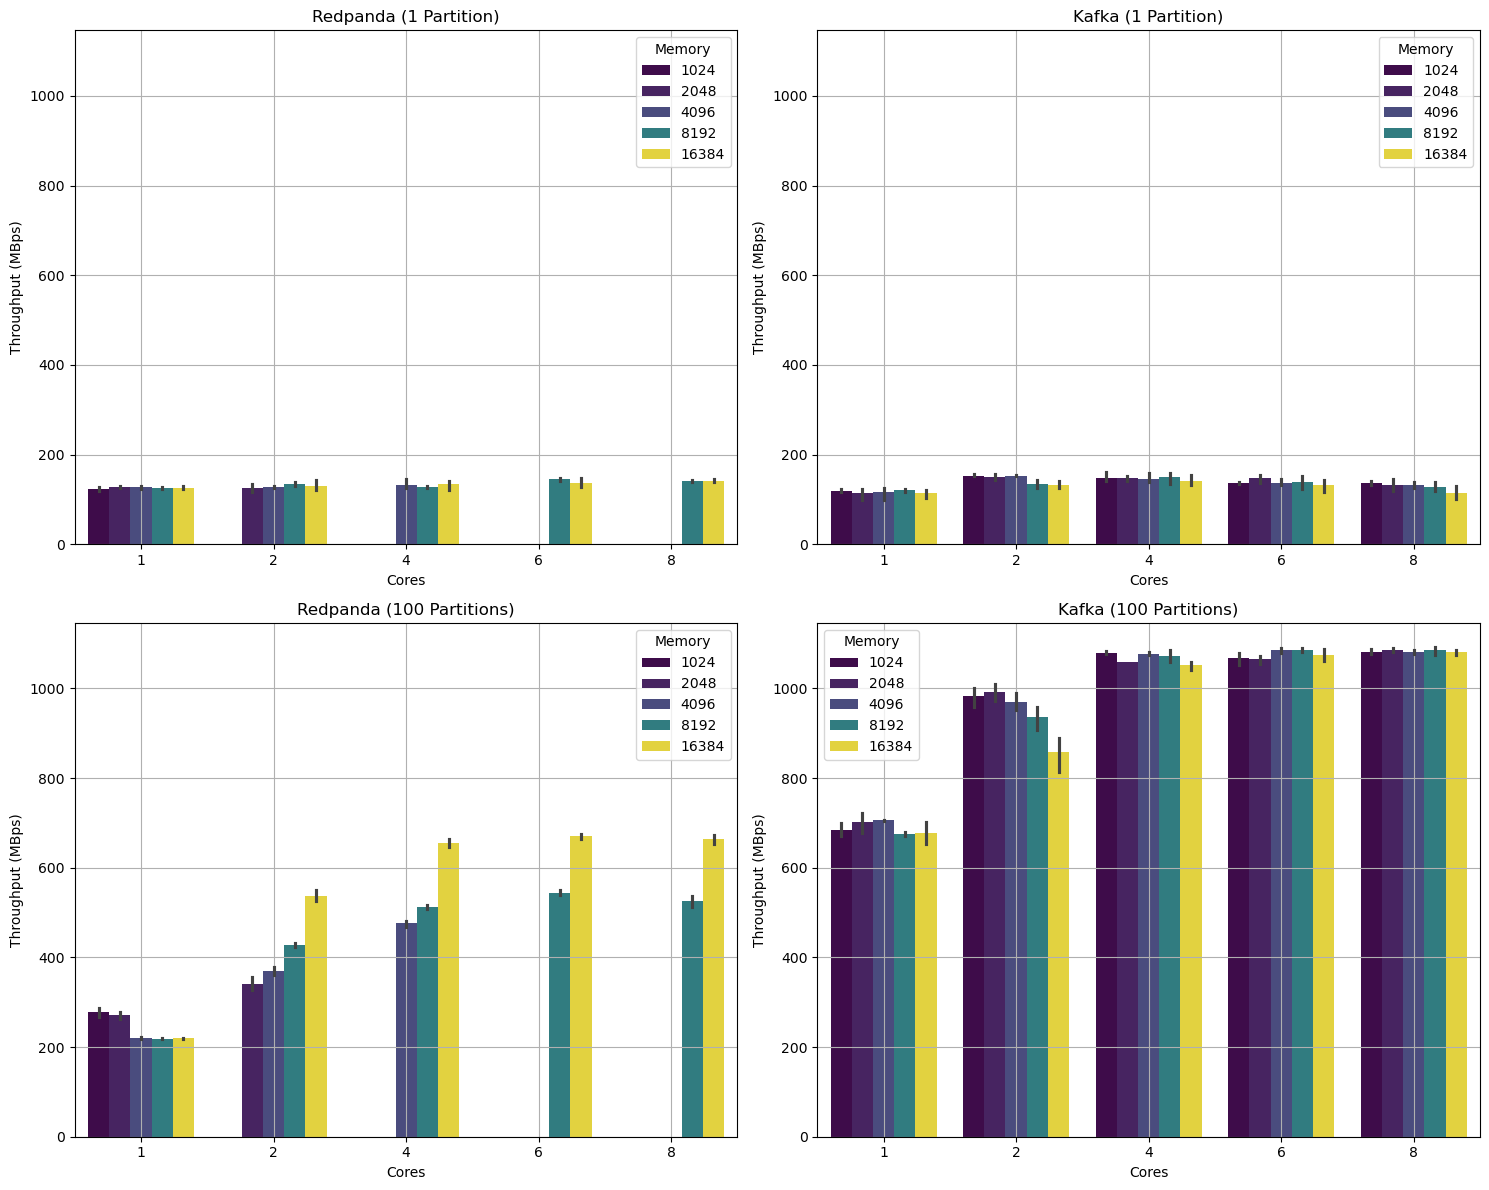

In [17]:
plot_combined_throughput(grappe_1, grappe_120)

In [18]:
ovhnvme_1 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="ovhnvme",
    type="memImpact",
    partitions=1,
)
ovhnvme_100 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="ovhnvme",
    type="memImpact",
    partitions=100,
)

KeyError: "None of ['exp_id'] are in the columns"